In [1]:
%matplotlib inline
%autosave 0

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Autosave disabled


# Import data

In [2]:
#ex5data = np.genfromtxt("/Users/nunopires/Documents/Coursera/machine-learning-ex5/ex5/ex5data1.txt", delimiter=',')
#print(ex5data[:5])
data = loadmat("/Users/nunopires/Documents/Coursera/machine-learning-ex5/ex5/ex5data1.mat",
       matlab_compatible = True)

print(data.keys())

for item in ['X', 'Xval', 'Xtest']:
    print(item, data[item].shape)

X = data['X']
y = data['y']
Xtest = data['Xtest']
ytest = data['ytest']
Xval = data['Xval']
yval = data['yval']

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])
X (12, 1)
Xval (21, 1)
Xtest (21, 1)


It's weird that they choose a training set with 12 data points, while cross validation and test sets have 21. Usually one would choose a 60:20:20 ratio...

### Plot

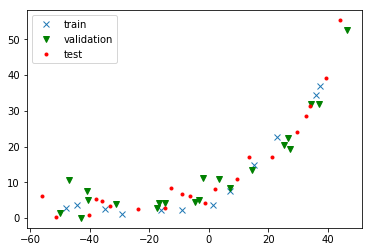

In [3]:
plt.plot(X, y, 'x', label='train');
plt.plot(Xval, yval, 'x', color = 'green', marker = 'v', label='validation');
plt.plot(Xtest, ytest, 'x', color = 'red', marker = '.', label='test');
plt.legend();

## Functions

In [4]:
def addIntercept(x):
    '''adds column of ones to start of array'''
    
    return np.column_stack((np.ones((x.shape[0])), x))

In [5]:
def computeJ(theta, X, Y, lamb):
    '''Compute cost for regularised linear regression'''
    
    theta = theta.reshape(X.shape[1],1)
    
    m = X.shape[0]
    
    h = np.dot(X, theta)
    J = np.sum((h - Y)**2) / (2*m)
    reg = (lamb/(2*m)) * np.sum((theta[1:])**2)
    
    return J + reg

# # test
# init_theta = np.ones((2))
# computeJ(init_theta, Xint, y, 1)

In [6]:
def trainLinearReg(X, y, lamb, method = 'BFGS'):
    '''estimate theta given train data and regularization parameter lambda'''

    # define initial theta
    init_theta = np.ones(X.shape[1])
    
    # minimize cost function
    theta = minimize(computeJ,
             x0 = init_theta,
             args = (X, y, lamb),
             method = method).x

    return theta

In [7]:
def polyFeatures(X, degree):
    '''returns a matrix where X is raised to the power of 1:degree'''
    
    x_poly = np.zeros((X.shape[0], degree))
    
    for i in range(degree):
        x_poly[:,i] = (X**(i+1)).T
        
    return x_poly    

In [8]:
def prepFeatures(x, degree):
    '''adds polynomial features, scales and intercept to matrix of features'''

    x = polyFeatures(x, degree)
    
    mu = np.zeros(x.shape[1])
    std = np.ones(x.shape[1])
    
    for i in range(1, x.shape[1]):
        mu[i] = np.mean(x[:,i])
        std[i] = np.std(x[:,i])

    mu = mu.reshape((-1, x.shape[1]))
    std = std.reshape((-1, x.shape[1]))
    
    x = (x - mu) / std
    
    x = addIntercept(x)
        
    return degree, mu, std, x

In [9]:
def predict(X, thetas):
    '''makes predictions for unidimensional X vector'''
    
    X = X.reshape((X.shape[0],-1))
    X = addIntercept(X)
    
    thetas = thetas.reshape((thetas.shape[0],-1))
    Y = np.dot(X, thetas)
    
    return Y

In [10]:
def LearningCurve(X, y, Xval, yval, lamb):
    '''Estimate theta for various training set sizes and calculate the respective 
    costs for the training and cross validation sets'''
    
    m = X.shape[0] # number of train observations -> number of iterations

    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))

    for i in range(1, m):

        temp_theta = trainLinearReg(X[:i,:], y[:i,:], lamb)
        temp_theta = temp_theta.flatten()

        # calculate costs using estimated theta (and without regularization)
        error_train[i] = computeJ(temp_theta, X[:i,:], y[:i,:], lamb = 0)
        error_val[i] = computeJ(temp_theta, Xval, yval, lamb = 0)
        
    return error_train, error_val

In [11]:
def LambdaCurve(X, y, Xval, yval, grid):
    '''Estimate theta for various training set sizes and calculate the respective 
    costs for the training and cross validation sets'''
    
    m = grid.size # number lambda to test -> number of iterations

    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))

    for idx, val in enumerate(grid):

        temp_theta = trainLinearReg(X, y, val)
        temp_theta = temp_theta.flatten()

        # calculate costs using estimated theta (and without regularization)
        error_train[idx] = computeJ(temp_theta, X, y, lamb = 0)
        error_val[idx] = computeJ(temp_theta, Xval, yval, lamb = 0)
        
    return error_train, error_val

## Transform features and train model

In [12]:
# choose polynomial degree [1:...]
degree, mu, std, Xint = prepFeatures(X, degree = 5)

# Train model
theta = trainLinearReg(Xint, y, lamb =  0)

### Plot regression line

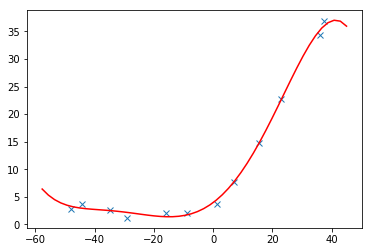

In [13]:
predX = np.linspace(min(X[:,0])*1.2, max(X[:,0])*1.2, 50).T
temp = polyFeatures(predX, degree)
temp = (temp - mu) / std
predY = predict(temp, theta)

# Plot
plt.plot(X, y, 'x', label='train');
plt.plot(predX, predY, color ='red');

## Learning curves

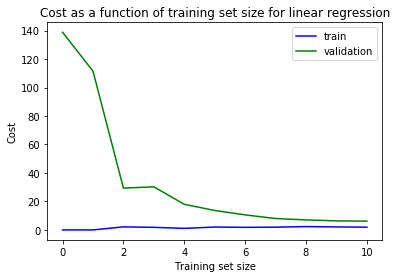

In [14]:
degree = 8

foo, foo, foo, Xint = prepFeatures(X, degree = degree)
foo, foo, foo, Xvalint = prepFeatures(Xval, degree = degree)

error_train, error_val = LearningCurve(Xint, y, Xvalint, yval, lamb = 3)

# Plot
plt.plot(error_train[1:], color = 'blue', label='train')
plt.plot(error_val[1:], color = 'green', label='validation')
plt.legend();
plt.title('Cost as a function of training set size for linear regression')
plt.xlabel('Training set size')
plt.ylabel('Cost');

Example from course tutorial is a little misleading because they artificially set y-axis to 0-150. This makes the difference between validation and training curves more obvious.

## Test regularization (lambda parameter)

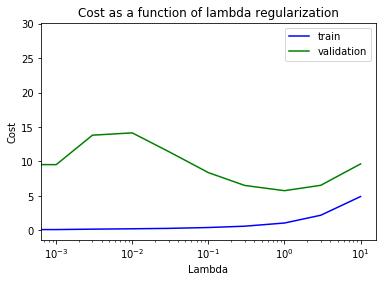

In [15]:
grid = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
degree = 8

foo, foo, foo, Xint = prepFeatures(X, degree = degree)
foo, foo, foo, Xvalint = prepFeatures(Xval, degree = degree)

error_train, error_val = LambdaCurve(Xint, y, Xvalint, yval, grid)

# Plot
plt.figure()
plt.xscale('log')
plt.plot(grid, error_train, color = 'blue', label='train')
plt.plot(grid, error_val, color = 'green', label='validation')
plt.legend();
plt.title('Cost as a function of lambda regularization')
plt.xlabel('Lambda')
plt.ylabel('Cost');

Lambda value of 3 is the best for 8th degree polynomial

# Calculate cost on test set

In [16]:
foo, foo, foo, Xint = prepFeatures(Xtest, degree = 8)

for i in ['Nelder-Mead', 'BFGS', 'Powell', 'TNC']:
    theta = trainLinearReg(Xint, ytest, lamb = 3, method = i)
    print(i, round(computeJ(theta, Xint, ytest, lamb = 0), 4))

Nelder-Mead 18.287
BFGS 3.172
Powell 3.1698
TNC 3.1606


Result from tutorial (using fmincg algorithm) was 3.8599.

Although these methods are derivative-less, they appear quite powerful (with the notable exception of the Nelder-Mead algorithm, which drastically failed to identify a decent minumum.